## **Project Title: Anomaly Detection in Credit Card Transactions**

### **Project Goal:**

Use unsupervised learning techniques to identify potential fraudulent credit card transactions without labeled data.

### **Dataset:**

Credit Card Fraud Detection – Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardataraud
also found in data folder

- 284,807 transactions

- Features are anonymized PCA components (V1 to V28) + Amount, Time

## **Part 1: EDA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [21]:
data = pd.read_csv('./data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [22]:
data.shape

(284807, 31)

In [23]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<Axes: >

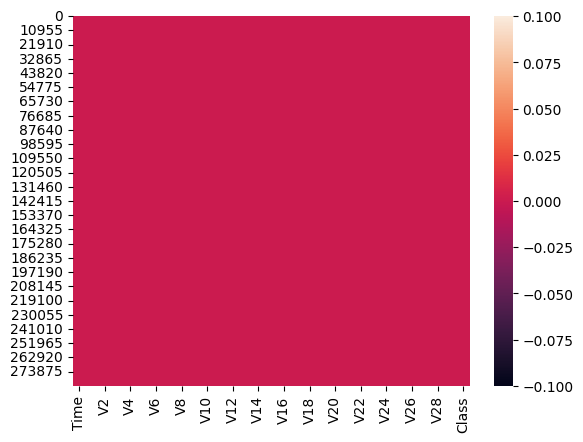

In [25]:
sns.heatmap(data.isnull())

Checking how many fraud cases exist compared to all transactions and calculates the fraud percentage.
This helps us understand how imbalanced the dataset is and how many anomalies the model should expect.

In [26]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [27]:
fraud_count = data['Class'].sum()
total = len(data)
fraud_ratio = fraud_count / total
print(f"Total transactions: {total}, Fraudulent: {fraud_count}, Fraud ratio: {fraud_ratio:.6f}")


Total transactions: 284807, Fraudulent: 492, Fraud ratio: 0.001727


In [28]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


from the describe function we can see that cols V1....V28 are standardized since Mean ≈ 0 and Std ≈ 1 so we must scale the other cols: Time and Amount in the next steps

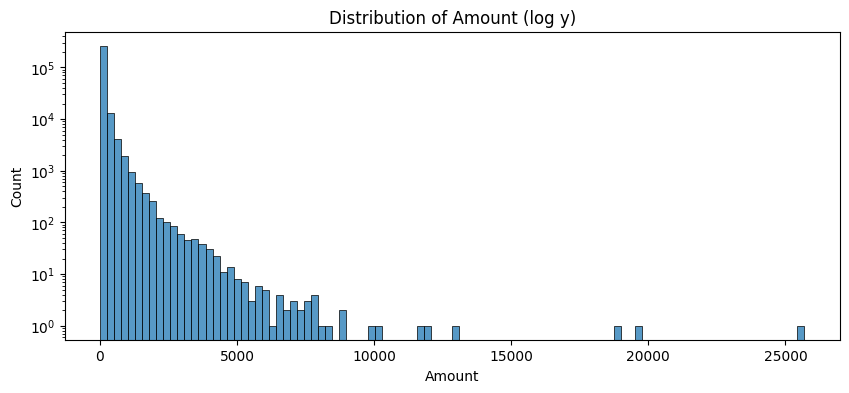

In [29]:
# Plot Amount distribution (log scale for better view)
plt.figure(figsize=(10,4))
sns.histplot(data['Amount'], bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of Amount (log y)')
plt.show()


From the histogram we conclude that: 
 - Most transactions involve very small amounts, the majority are under $100.
 - As the transaction amount increases, the number of transactions drops sharply, showing a right-skewed distribution.
 - Very large transactions (above $5,000, $10,000+, $20,000+) are extremely rare, appearing as isolated bars.

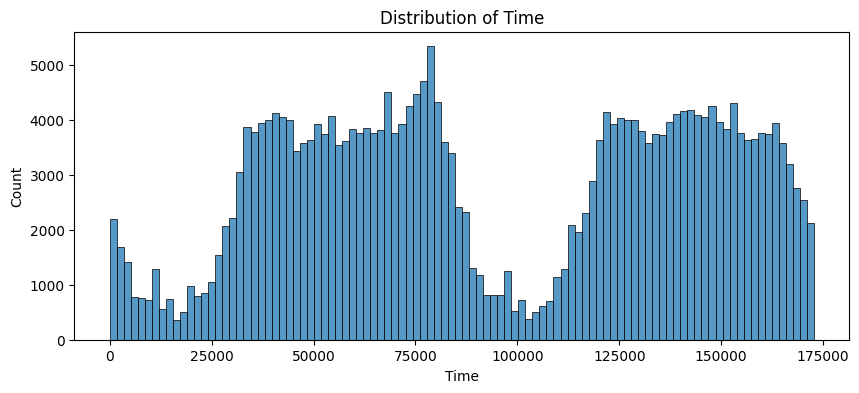

In [30]:
# Time distribution
plt.figure(figsize=(10,4))
sns.histplot(data['Time'], bins=100)
plt.title('Distribution of Time')
plt.show()

From the graph we can conclude that:
 - The plot shows two clear peaks of high activity.
 This means transactions happen in waves, likely representing busy daytime periods vs. quieter nighttime hours.
 - There are low-activity gaps between the peaks, suggesting times of day when customers rarely make transactions.
 - Since “Time” represents the number of seconds from the first transaction, these patterns reflect daily cycles in user behavior.

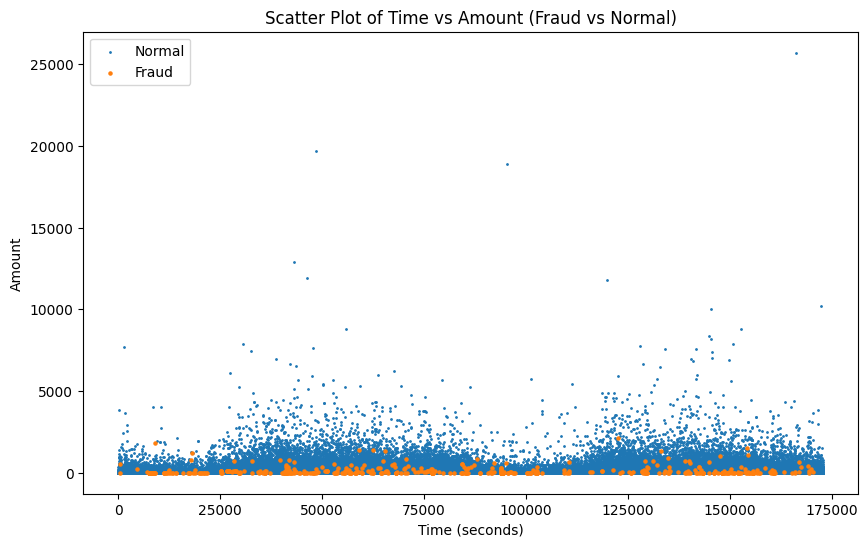

In [31]:

# Prepare data
fraud = data[data['Class'] == 1]
normal = data[data['Class'] == 0]

# Create scatter plot
plt.figure(figsize=(10,6))

plt.scatter(normal['Time'], normal['Amount'], s=1, label='Normal')
plt.scatter(fraud['Time'], fraud['Amount'], s=5, label='Fraud')

plt.xlabel('Time (seconds)')
plt.ylabel('Amount')
plt.legend()
plt.title('Scatter Plot of Time vs Amount (Fraud vs Normal)')

plt.show()

The scatter plot shows that fraud transactions occur across the entire time range and mostly involve small amounts. High-value transactions are almost always legitimate. There’s significant overlap between fraud and non-fraud points, so Time and Amount alone are not enough to detect fraud, and we must rely on deeper PCA components (V1–V28) and anomaly detection models.

## **Part 2: Data Preprocessing**

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
data[['Time','Amount']] = scaler.fit_transform(data[['Time','Amount']])

In [33]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,0.55,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,0.27,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,0.01,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,0.31,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,0.00,0.00
50%,0.49,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,0.00,0.00
75%,0.81,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,0.00,0.00
max,1.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,1.00,1.00


In [44]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(data.drop('Class', axis=1)))
pca.explained_variance_

array([1.15126909e+01, 8.18056741e+00, 2.31284864e+00, 2.00553299e+00,
       1.90735134e+00, 1.77524922e+00, 1.53097132e+00, 1.42658609e+00,
       1.20699875e+00, 1.18567133e+00, 1.04690344e+00, 9.99559819e-01,
       9.90848898e-01, 9.19657110e-01, 8.40383191e-01, 7.67829942e-01,
       7.21800980e-01, 7.03160252e-01, 6.62726893e-01, 5.94544071e-01,
       5.39708097e-01, 5.28272831e-01, 3.90170279e-01, 3.66830455e-01,
       2.76357739e-01, 2.32677137e-01, 1.62921693e-01, 1.08964748e-01,
       3.85189343e-02, 7.82201863e-06, 2.14644228e-14, 0.00000000e+00])

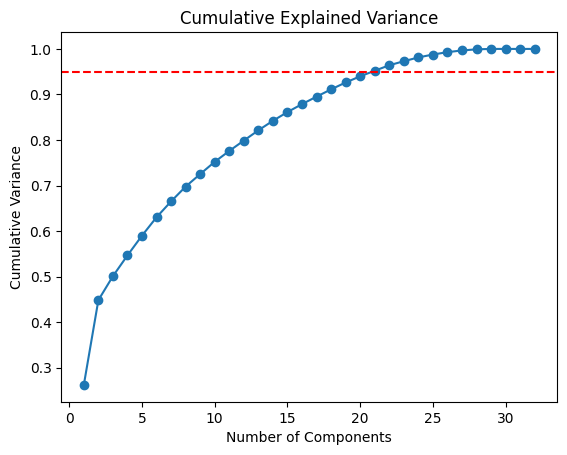

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()                 # IMPORTANT: keeps all components
pca.fit(data.drop('Class', axis=1))

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Explained Variance")
plt.show()


from the graph above we can see that:
- Red dashed line = 95% variance threshold
- Curve crosses 95% around component 23

so we need to set n_components = 23 to capture 95% of the information.

In [46]:
pca = PCA(n_components=23)
X_pca = pca.fit_transform(data.drop('Class', axis=1))
X_pca.shape

(284807, 23)

## 🌲 Isolation Forest (iForest) Main Ideas
**Goal:** Anomaly detection (unsupervised outlier detection).

**Core Principle:** Anomalies (outliers) are few and structurally different from the normal data points, meaning they are easier to isolate than normal points.

**1. How It Works**
- Isolation Trees (iTrees): The algorithm builds an ensemble of simple binary trees (the "forest"). Unlike standard decision trees, iTrees are built to isolate points, not to classify them.

- Random Partitioning: Each split in an iTree is made by randomly selecting a feature and then randomly selecting a split value within the range of that feature. This recursive splitting aims to quickly partition the space.

**2. Anomaly Scoring**
- Path Length: The key concept is the path length—the number of edges a data point traverses from the root of the tree until it is isolated at a leaf node.

- Anomalies: Anomalies are isolated closer to the root, resulting in a shorter average path length.

- Normal Points: Normal data points are grouped together and require more random partitions to be separated, resulting in a longer average path length.

- Anomaly Score: The final anomaly score for a point is derived from its average path length across all iTrees in the forest. Shorter average path length = higher anomaly score (more likely to be an outlier).

In [47]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Use PCA-transformed data (23 components = 95% variance)
X = X_pca

# True labels (only for evaluation, not for training)
y_true = data['Class']

# Fraud ratio (used as contamination factor)
fraud_ratio = y_true.mean()
print("Fraud ratio (contamination):", fraud_ratio)

Fraud ratio (contamination): 0.001727485630620034


In [48]:
iso = IsolationForest(
    n_estimators=100,
    contamination=fraud_ratio,   # extremely important
    random_state=42,
    verbose=1
)

iso.fit(X)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


,n_estimators,100
,max_samples,'auto'
,contamination,np.float64(0....7485630620034)
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,1
,warm_start,False


In [49]:
y_pred = iso.predict(X)

# Convert to 0=normal, 1=fraud
y_pred = np.where(y_pred == -1, 1, 0)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [50]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))


[[283986    329]
 [   329    163]]
              precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988    284315
           1     0.3313    0.3313    0.3313       492

    accuracy                         0.9977    284807
   macro avg     0.6651    0.6651    0.6651    284807
weighted avg     0.9977    0.9977    0.9977    284807



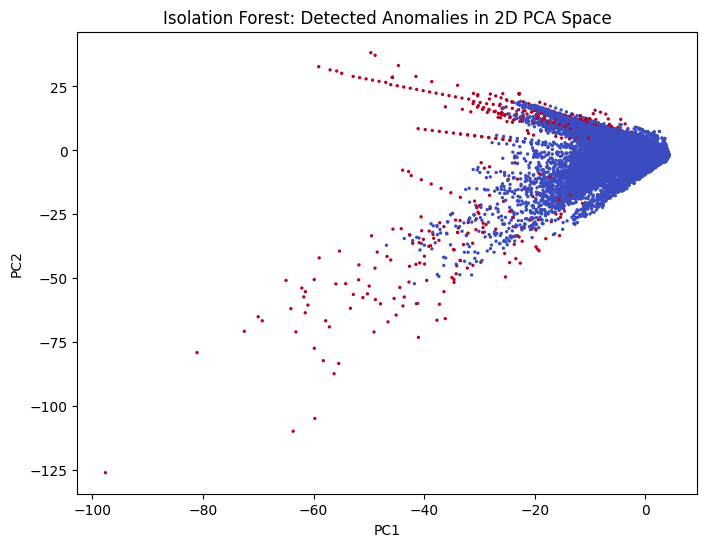

In [ ]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(data.drop("Class", axis=1))

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_pred, s=2, cmap='coolwarm')
plt.title("Isolation Forest: Detected Anomalies in 2D PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


since the model misses many fraud cases

Precision is low → too many false alarms

so to improve the performance we will try One Class SVM

## **One-Class Support Vector Machine (OC-SVM) Main Ideas**
**Goal:** Anomaly/Outlier detection and Novelty detection.

**Core Principle:** This is an unsupervised method that learns the boundary of the normal class only. It works by finding the optimal hyperplane that separates the data points from the origin in a high-dimensional feature space.

**1. How It Works (Boundary Definition)**
- Training Data: OC-SVM is trained only on normal (majority) instances. It does not require labeled examples of anomalies.

- Feature Space Transformation: It uses the Kernel Trick (e.g., RBF kernel is the default) to implicitly map the data into a higher-dimensional space where the normal data can be linearly separated from the origin.

- Outlier Boundary: The algorithm finds a hyperplane that maximally separates the training data (normal points) from the origin, thereby creating a tightly defined "region of normalcy".

**2. Key Hyperparameters and Concepts**
- Support Vectors: Similar to standard SVM, these are the data points that lie closest to the boundary (hyperplane) and define its shape.

- nu: This crucial hyperparameter controls the balance. It acts as an upper bound on the fraction of training errors (normal points classified as outliers) and a lower bound on the fraction of Support Vectors. In essence, it controls the sensitivity of the model (how many outliers you expect).

- Decision Function:

    1. Data points that fall inside the learned boundary are classified as Normal (or inliers).

    2. Data points that fall outside the boundary are flagged as Anomalies (or outliers).

In [59]:
from sklearn.svm import OneClassSVM
# OC-SVM is often sensitive to parameters and slower than IForest
# Use the RBF kernel and experiment with 'nu' (similar to contamination)
oc_svm = OneClassSVM(kernel='rbf', nu=0.0017, gamma='scale')

In [60]:
# Use only the training data (excluding the 'Class' column)
oc_svm.fit( data.drop('Class', axis=1) )
# The decision_function gives a score (less than 0 is an anomaly)
y_pred_ocsvm = oc_svm.predict( data.drop('Class', axis=1) )

In [62]:
# Convert predictions:
# +1 = normal, -1 = anomaly  --> make it match your dataset labels 0/1
y_pred = np.where(y_pred_ocsvm == 1, 0, 1)


In [63]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[283405    910]
 [   385    107]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.11      0.22      0.14       492

    accuracy                           1.00    284807
   macro avg       0.55      0.61      0.57    284807
weighted avg       1.00      1.00      1.00    284807

